# Importing Libraries

In [1]:
import pandas as pd
import numpy as np

import os
import sys

import librosa
import librosa.display
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

from IPython.display import Audio

import tensorflow as tf
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Flatten, Dropout, BatchNormalization
from tensorflow.keras.callbacks import ModelCheckpoint

import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning) 

In [12]:
import os
import pandas as pd

PATH = '/kaggle/input/indian-emotion/Audio Mode Only/'
file_emotion = []
file_path = []

emotions = ['Anger', 'Disgust', 'Fear', 'Happy', 'Neutral', 'Sad']

for emotion in emotions:
    emotion_folder = os.path.join(PATH, emotion)
    print(f"Checking folder: {emotion_folder}") 
    
    if os.path.isdir(emotion_folder):
        for file in os.listdir(emotion_folder):
            file_full_path = os.path.join(emotion_folder, file)
            #print(f"Found file: {file_full_path}") 
            file_path.append(file_full_path)
            file_emotion.append(emotion.lower())
    else:
        print(f"Folder not found: {emotion_folder}")

emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])
path_df = pd.DataFrame(file_path, columns=['Path'])
crema_df = pd.concat([emotion_df, path_df], axis=1)
crema_df.to_csv("crema_df.csv", index=False)
crema_df.head()


Checking folder: /kaggle/input/indian-emotion/Audio Mode Only/Anger
Checking folder: /kaggle/input/indian-emotion/Audio Mode Only/Disgust
Checking folder: /kaggle/input/indian-emotion/Audio Mode Only/Fear
Checking folder: /kaggle/input/indian-emotion/Audio Mode Only/Happy
Checking folder: /kaggle/input/indian-emotion/Audio Mode Only/Neutral
Checking folder: /kaggle/input/indian-emotion/Audio Mode Only/Sad


Emotions                                               Path
0    anger  /kaggle/input/indian-emotion/Audio Mode Only/A...
1    anger  /kaggle/input/indian-emotion/Audio Mode Only/A...
2    anger  /kaggle/input/indian-emotion/Audio Mode Only/A...
3    anger  /kaggle/input/indian-emotion/Audio Mode Only/A...
4    anger  /kaggle/input/indian-emotion/Audio Mode Only/A...

# Dataset

In [3]:
crema_df.to_csv('/kaggle/working/pumave.csv', index=False)
plt.title('Count of Emotions')
sns.countplot(x = crema_df.Emotions)
plt.ylabel('Count')
plt.xlabel('Emotions')
sns.despine(top = True, right = True, left = False, bottom = False)
plt.show()

In [8]:
def waveplot(data, sr, emotion, ax):
    ax.plot(data)
    ax.set_title(f'Waveplot for {emotion}')
    ax.set_xlabel('Time')
    ax.set_ylabel('Amplitude')

def spectrogram(data, sr, emotion, ax):
    S = librosa.stft(data)
    S_dB = librosa.amplitude_to_db(np.abs(S), ref=np.max)
    img = librosa.display.specshow(S_dB, sr=sr, x_axis='time', y_axis='log', ax=ax)
    ax.set_title(f'Spectrogram for {emotion}')
    return img

# Visualization

In [9]:
crema_df['Emotions'].unique()

array(['anger', 'disgust', 'fear', 'happy', 'neutral', 'sad'],
      dtype=object)

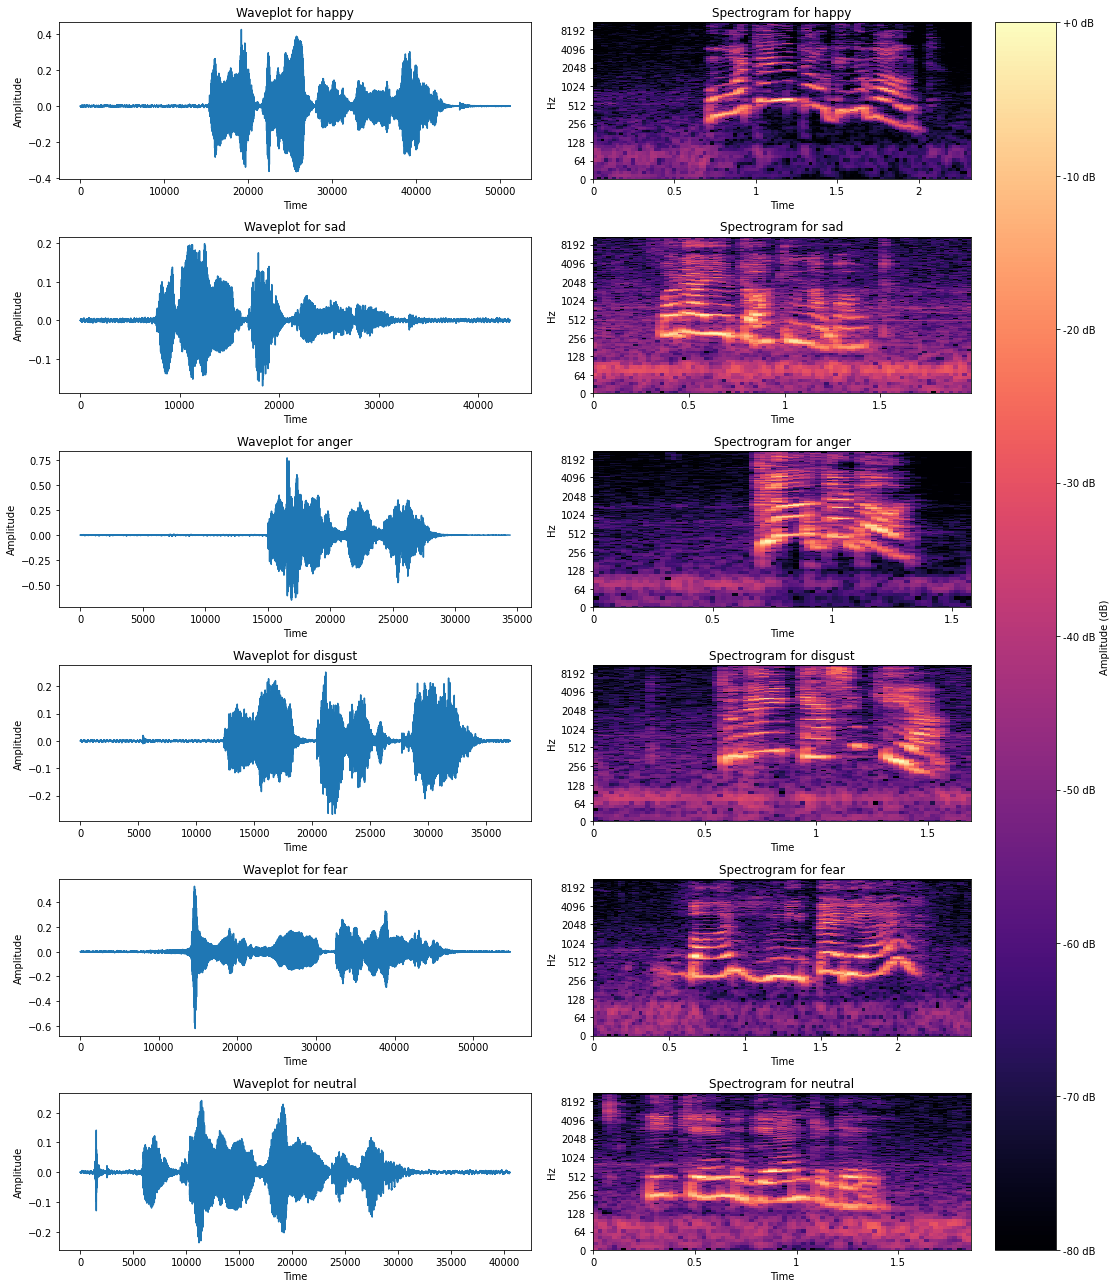

In [10]:
emotions = ['happy', 'sad', 'anger', 'disgust', 'fear', 'neutral']
fig, axs = plt.subplots(len(emotions), 2, figsize=(15, 3 * len(emotions)))

for i, emotion in enumerate(emotions):
    emotion_paths = crema_df.Path[crema_df.Emotions == emotion]
    if not emotion_paths.empty:
        path = np.array(emotion_paths)[0]  # Take the first path
        data, sr = librosa.load(path)
        waveplot(data, sr, emotion, axs[i, 0])
        img = spectrogram(data, sr, emotion, axs[i, 1])
    else:
        print(f"No paths found for emotion '{emotion}'")

plt.tight_layout()
cbar = fig.colorbar(img, ax=axs[:, 1], format="%+2.0f dB")
cbar.ax.set_ylabel('Amplitude (dB)')
plt.show()

# MFCC Extraction

In [ ]:
#labels = {'disgust':0,'happy':1,'sad':2,'neutral':3,'fear':4,'angry':5}
#pumave_df.replace({'Emotions':labels},inplace=True)

In [14]:
num_mfcc=13
n_fft=2048
hop_length=512
SAMPLE_RATE = 22050
data = {
        "labels": [],
        "mfcc": []
    }
for i in range(1232):
    data['labels'].append(crema_df.iloc[i,0])
    signal, sample_rate = librosa.load(crema_df.iloc[i,1], sr=SAMPLE_RATE)
    mfcc = librosa.feature.mfcc(signal, sample_rate, n_mfcc=13, n_fft=2048, hop_length=512)
    mfcc = mfcc.T
    data["mfcc"].append(np.asarray(mfcc))
    if i%500==0:
        print(i)

0
500
1000


# Padding MFCC to make them of equal length

In [15]:
X = np.asarray(data['mfcc'])
y = np.asarray(data["labels"])

In [16]:
X = tf.keras.preprocessing.sequence.pad_sequences(X)
X.shape

(1232, 237, 13)

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)
X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size=0.2)

In [18]:
print(X_train.shape,y_train.shape,X_validation.shape,y_validation.shape,X_test.shape,y_test.shape)

(886, 237, 13) (886,) (222, 237, 13) (222,) (124, 237, 13) (124,)


# Model

In [32]:
def build_model(input_shape):
    model = tf.keras.Sequential([
        LSTM(128, input_shape=input_shape, return_sequences=True),
        LSTM(64),
        Dense(64, activation='relu'),
        Dropout(0.3),
        Dense(6, activation='softmax')
    ])
    return model

input_shape = (237, 13)
model = build_model(input_shape)

optimiser = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimiser,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 237, 128)          72704     
_________________________________________________________________
lstm_3 (LSTM)                (None, 64)                49408     
_________________________________________________________________
dense_2 (Dense)              (None, 64)                4160      
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 6)                 390       
Total params: 126,662
Trainable params: 126,662
Non-trainable params: 0
_________________________________________________________________


# Training

In [33]:
print("Model input shape:", model.input_shape)
print("X_train shape:", X_train.shape)

Model input shape: (None, 237, 13)
X_train shape: (886, 237, 13)


In [35]:
history = model.fit(X_train, y_train, validation_data=(X_validation, y_validation), batch_size=32, epochs=60)

Epoch 1/60
28/28 [==============================] - 1s 28ms/step - loss: 0.5022 - accuracy: 0.8104 - val_loss: 1.2006 - val_accuracy: 0.5631
Epoch 2/60
28/28 [==============================] - 1s 25ms/step - loss: 0.4558 - accuracy: 0.8318 - val_loss: 1.2318 - val_accuracy: 0.5721
Epoch 3/60
28/28 [==============================] - 1s 25ms/step - loss: 0.5027 - accuracy: 0.8047 - val_loss: 1.3980 - val_accuracy: 0.4414
Epoch 4/60
28/28 [==============================] - 1s 25ms/step - loss: 0.5693 - accuracy: 0.7698 - val_loss: 1.3345 - val_accuracy: 0.4865
Epoch 5/60
28/28 [==============================] - 1s 25ms/step - loss: 0.4663 - accuracy: 0.8375 - val_loss: 1.4506 - val_accuracy: 0.4685
Epoch 6/60
28/28 [==============================] - 1s 25ms/step - loss: 0.4331 - accuracy: 0.8465 - val_loss: 1.5472 - val_accuracy: 0.5721
Epoch 7/60
28/28 [==============================] - 1s 25ms/step - loss: 0.5816 - accuracy: 0.7822 - val_loss: 1.3393 - val_accuracy: 0.5225
Epoch 8/60
28

# Evaluation

In [43]:
print("X_test dtype:", X_test.shape)
print("y_test dtype:", y_test.shape)

X_test dtype: (124, 237, 13)
y_test dtype: (124,)


In [41]:
X_test = X_test.astype(np.float32)
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y_test = le.fit_transform(y_test).astype(np.int32)
print("X_test dtype:", X_test.dtype)
print("y_test dtype:", y_test.dtype)
print("Unique values in y_test:", np.unique(y_test))

X_test dtype: float32
y_test dtype: int32
Unique values in y_test: [0 1 2 3 4 5]


4/4 [==============================] - 0s 11ms/step - loss: 2.7443 - accuracy: 0.5242
Testing Accuracy:  52.419352531433105 %


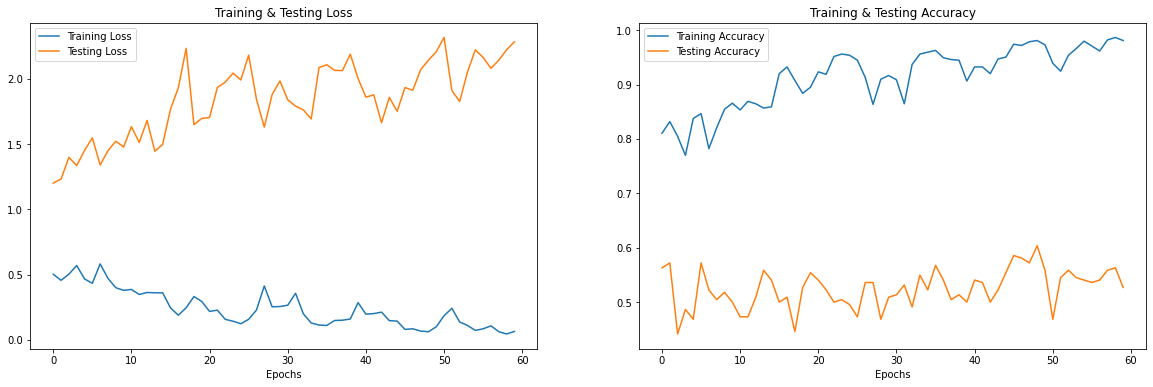

In [47]:
print("Testing Accuracy: " , model.evaluate(X_test,y_test)[1]*100 , "%")

epochs = [i for i in range(60)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
test_acc = history.history['val_accuracy']
test_loss = history.history['val_loss']

fig.set_size_inches(20,6)
ax[0].plot(epochs , train_loss , label = 'Training Loss')
ax[0].plot(epochs , test_loss , label = 'Testing Loss')
ax[0].set_title('Training & Testing Loss')
ax[0].legend()
ax[0].set_xlabel("Epochs")

ax[1].plot(epochs , train_acc , label = 'Training Accuracy')
ax[1].plot(epochs , test_acc , label = 'Testing Accuracy')
ax[1].set_title('Training & Testing Accuracy')
ax[1].legend()
ax[1].set_xlabel("Epochs")
plt.show()

In [45]:
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)
print("Test Accuracy: ",test_acc)

Test Accuracy:  0.524193525314331
